### For a given hybrid focal plane layout how much sky do we cover as a function of time

In [1]:
%matplotlib inline

from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
from lsst.sims.maf.plots import PlotHandler
import healpy as hp

In [2]:
# This is needed to avoid an error when a metric is redefined
from lsst.sims.maf.metrics import BaseMetric
try:
    del metrics.BaseMetric.registry['__main__.selectChipsMetric']
except KeyError:
    pass

In [3]:
class selectChipsMetric(BaseMetric):
    """
    Pass a set of sensors or rafts for a given vendor
    """

    def __init__(self, cols=None, sensors=None, **kwargs):
        if sensors is None:
            self.sensors = []
        else:
            self.sensors = sensors

        if cols is None:
            cols = []
        super(selectChipsMetric, self).__init__(
            col=cols, metricDtype=float, **kwargs)

    def _selectChips(self, chipName):
        """
        given a list of sensors increment count if a region of the sky covers
        that sensor.
        """
        count = 0
        for chip in chipName:
            for sensor in self.sensors:
                if sensor in chip:
                    count += 1
                    break
        return count

    def run(self, dataSlice, slicePoint=None):

        if 'chipNames' not in slicePoint.keys():
            raise ValueError('No chipname info, need to set useCamera=True '
                             'with a spatial slicer.')

        result = self._selectChips(slicePoint['chipNames'])

        if result == 0:
            result = self.badval
        return result

In [4]:
# Set the database and query
database = 'baseline2018a.db'
# sqlWhere = 'filter = "r" and night < 400'
opsdb = db.OpsimDatabase(database)
outDir = 'Camera'
resultsDb = db.ResultsDb(outDir=outDir)
nside = 512

In [5]:
# Change to observationStartMJD from expMJD

# define rafts for a given vendor

rafts = ['R:0,1', 'R:0,2', 'R:0,3',
         'R:1,0', 'R:1,1', 'R:1,2', 'R:1,3', 'R:1,4',
         'R:2,0', 'R:2,1', 'R:2,2', 'R:2,3', 'R:2,4',
         'R:3,0', 'R:3,1', 'R:3,2', 'R:3,3', 'R:3,4',
         'R:4,1', 'R:4,2', 'R:4,3']

rafts2 = ['R:0,1',  'R:0,3',
          'R:1,1', 'R:1,3',
          'R:2,0', 'R:2,2', 'R:2,4',
          'R:3,1', 'R:3,3',
          'R:4,1',  'R:4,3']

rafts1 = ['R:2,2', 'R:2,3', 'R:2,4',
          'R:3,0', 'R:3,1', 'R:3,2', 'R:3,3', 'R:3,4',
          'R:4,0', 'R:4,1', 'R:4,2', 'R:4,3']

metric1 = metrics.CountMetric('observationStartMJD')
metric2 = selectChipsMetric('observationStartMJD', sensors=rafts2)
slicer = slicers.HealpixSlicer(nside=nside, useCamera=True)
slicer2 = slicers.HealpixSlicer(nside=nside, useCamera=True)
summaryMetrics = [metrics.SumMetric()]


Healpix slicer using NSIDE=512, approximate resolution 6.870973 arcminutes
Healpix slicer using NSIDE=512, approximate resolution 6.870973 arcminutes


In [6]:
# run metric with all sensors

sqlWhere = ('filter = "z" and observationStartMJD < 59853.04 and '
            'fieldRA < %f and fieldDec > %f and fieldDec < 0') % (311., -27.)
bundle1 = metricBundles.MetricBundle(metric1, slicer, sqlWhere,
                                     summaryMetrics=summaryMetrics)
bundle2 = metricBundles.MetricBundle(metric2, slicer2, sqlWhere,
                                     summaryMetrics=summaryMetrics)
bgFull = metricBundles.MetricBundleGroup({
    'Full': bundle1, 'Hybrid': bundle2}, opsdb,
    outDir=outDir, resultsDb=resultsDb)
bgFull.runAll()
normPixels = len((np.where(bundle1.metricValues > 0))[0])

Querying database SummaryAllProps with constraint filter = "z" and observationStartMJD < 59853.04 and fieldRA < 311.000000 and fieldDec > -27.000000 and fieldDec < 0 for columns ['fieldRA', 'rotSkyPos', 'observationStartMJD', 'fieldDec']
Found 11 visits
Running:  ['Full', 'Hybrid']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


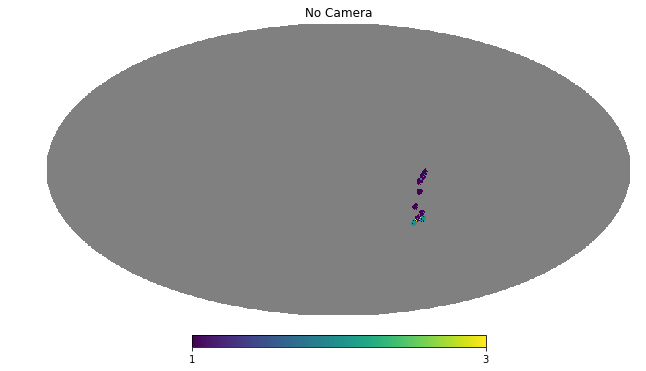

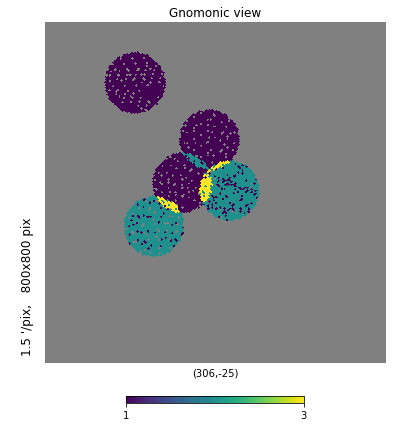

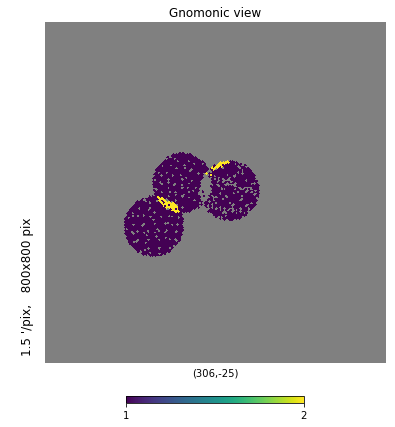

In [7]:
# plot camera
hp.mollview(bundle1.metricValues, title='No Camera')
hp.gnomview(bundle1.metricValues, xsize=800, ysize=800, rot=(306., -25., 0))
hp.gnomview(bundle2.metricValues, xsize=800, ysize=800, rot=(306., -25., 0), min=1, max=2)

In [8]:
# loop over seasons and calculate the depth
nSeasons = 10
seasonLength = 50
nRepeats = [1, 2, 4, 8, 10]
numPixels = np.zeros((nSeasons, len(nRepeats)))
for i in range(nSeasons):
    sqlWhere = ('filter = "r" and night < %f and fieldRA < %f and'
                ' fieldDec > %f and fieldDec < 0') \
                % ((i+1)*seasonLength, 15., -15.)
    bundle2 = metricBundles.MetricBundle(
        metric2, slicer, sqlWhere, summaryMetrics=summaryMetrics)
    bgHybrid = metricBundles.MetricBundleGroup(
        {'Hybrid': bundle2}, opsdb, outDir=outDir, resultsDb=resultsDb)
    bgHybrid.runAll()
    for j, repeat in enumerate(nRepeats):
        numPixels[i, j] = len((np.where(bundle2.metricValues > repeat))[0])

Querying database SummaryAllProps with constraint filter = "r" and night < 50.000000 and fieldRA < 15.000000 and fieldDec > -15.000000 and fieldDec < 0 for columns ['fieldRA', 'rotSkyPos', 'observationStartMJD', 'fieldDec']
Found 57 visits
Running:  ['Hybrid']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter = "r" and night < 100.000000 and fieldRA < 15.000000 and fieldDec > -15.000000 and fieldDec < 0 for columns ['fieldRA', 'rotSkyPos', 'observationStartMJD', 'fieldDec']
Found 143 visits
Running:  ['Hybrid']


/home/docmaf/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/sims_coordUtils/2.8.0.sims/python/lsst/sims/coordUtils/CameraUtils.py:382: MultipleChipWarning: An object has landed on multiple chips.  You asked for this not to happen.
We will return only one of the chip names.  If you want both, try re-running with the kwarg allow_multiple_chips=True.
Offending chip names were ['R:0,4 S:2,0,A', 'R:0,4 S:2,0,B']
Offending pupil coordinate point was -0.019792645214 0.020511528636

  category=MultipleChipWarning)


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter = "r" and night < 150.000000 and fieldRA < 15.000000 and fieldDec > -15.000000 and fieldDec < 0 for columns ['fieldRA', 'rotSkyPos', 'observationStartMJD', 'fieldDec']
Found 143 visits
Running:  ['Hybrid']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter = "r" and night < 200.000000 and fieldRA < 15.000000 and fieldDec > -15.000000 and fieldDec < 0 for columns ['fieldRA', 'rotSkyPos', 'observationStartMJD', 'fieldDec']
Found 143 visits
Running:  ['Hybrid']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter = "r" and night < 250.000000 and fieldRA < 15.000000 and fieldDec > -15.000000 and fieldDec < 0 for columns ['fieldRA', 'rotSkyPos', 'observa

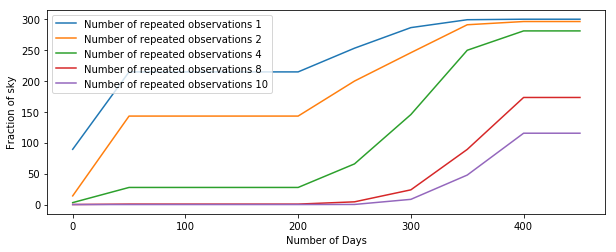

In [9]:
# plot repeats as a function of time
fig = plt.figure(figsize=(10, 3.75))
ax = fig.add_subplot(111)
ax.set_xlabel('Number of Days')
ax.set_ylabel('Fraction of sky')
for i in range(len(nRepeats)):
    plt.plot(seasonLength*np.arange(nSeasons), numPixels[:, i]*100./normPixels,
             label='Number of repeated observations %d' % (nRepeats[i]))
ax.legend(loc=0)